# Preprocessing Steps

In [46]:
import pandas as pd
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_csv('heart.csv')

In [48]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [49]:
len(df)

918

In [50]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [51]:
col = list(df.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(df[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope HeartDisease
Numerical Features : Age RestingBP Cholesterol MaxHR Oldpeak


## Categorical Encoding

In [52]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [53]:
def encode(df, columns):
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

In [54]:
cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = encode(df, cols)

# Feature Engineering

In [55]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

In [56]:
def standardScale(df, columns):
    for col in columns:
        df[col] = ss.fit_transform(df[[col]])
    return df

def minMaxScale(df, columns):
    for col in columns:
        df[col] = mms.fit_transform(df[[col]])
    return df

In [57]:
mms_cols = ['Oldpeak']
ss_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']

In [58]:
df = minMaxScale(df, mms_cols)
df = standardScale(df, ss_cols)

In [59]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


## Correlation w/ HeartDisease 

Text(0.5, 1.0, 'Correlation w.r.t HeartDisease')

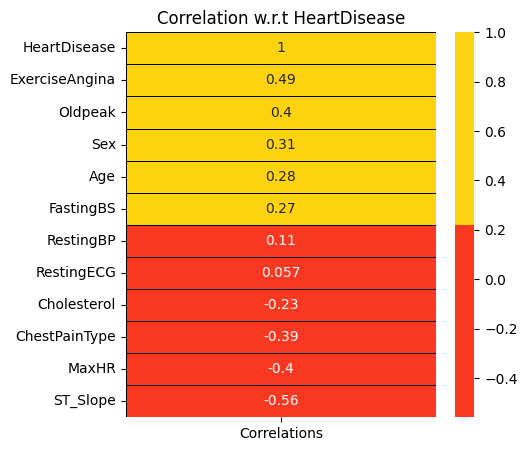

In [60]:
colors = ['#F93822','#FDD20E']
corr = df.corrwith(df['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black')
plt.title('Correlation w.r.t HeartDisease')

## Feature selection for categorical features - Chi Squared Test

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
features = df.loc[:,categorical_features[:-1]]
target = df.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = chi2,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['Chi Squared Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'Chi Squared Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Categorical Features')

## Feature selection for categorical features - Anova Test

In [ ]:
from sklearn.feature_selection import f_classif

features = df.loc[:,numerical_features]
target = df.loc[:,categorical_features[-1]]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

# Splitting into Training and Testing

In [ ]:
from sklearn.model_selection import train_test_split

Dropped - Reason \
RestingECG - last in Chi Squared Score \
RestingBP - last in ANOVA Score \ 
Both also have very low to zero correlation with HeartDisease

In [66]:
features = df[df.columns.drop(['HeartDisease','RestingBP','RestingECG'])].values
target = df['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 2)